In [0]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import erf
from scipy.optimize import curve_fit, dual_annealing

In [0]:
Data={'World':[580,845,1317,2015,2800,4581,6058,7813,9823,11950,14553,17391,20630,24545,28266,31439,34876,37552,40553,43099,45134,59287,64438,67100,69197,71329,73332,75184,
               75700,76677,77673,78651,79205,80087,80828,81820,83112,84615,86604,88585,90443,93016,95314,98425,102050,106099,109991,114381,118948,126214,134509,145416,156475,
               169517,182414,198159,218744,244902,275550,304979,337459,378830,422574,471035,531865,596366,663127,723390,784741,858361,935232,1015065,1116662,1201483,1272901,
               1348564,1433638,1518126,1603694,1698881,1779842,1852365,1923937],
      'USA':[53,57,60,60,63,68,75,100,124,158,221,319,435,541,704,994,1301,1697,2247,2943,3680,4663,6411,9259,13789,19383,24207,33566,43781,54856,68211,85435,104126,123578,143491,163788,188530,215003,244877,277161,311357,338425,369635,403095,435030,469124,502876,532879,
             560300,586941],
      'Spain':[2,3,9,13,25,33,58,84,120,165,228,282,401,525,674,1231,1695,2277,3146,5232,6391,7988,9942,11826,14769,18077,21571,25496,28768,35136,42058,49515,57786,65719,73235,80110,87956,95923,104118,112065,119199,126168,131646,136675,141942,148220,153222,158273,163027,
               166831,170099],
      'Italy':[157,229,323,470,655,889,1128,1701,2036,2502,3089,3858,4636,5883,7375,9172,10149,12462,15113,17660,21157,24747,27980,31506,35713,41035,47021,53578,59138,63927,69176,74386,80589,86498,92472,97689,101739,105792,110574,115242,119827,124632,128948,132547,135586,139422,143626,147577,152271,
               156363,159516],
      'Germany':[16,18,26,48,74,79,130,165,203,262,545,670,800,1040,1224,1565,1966,2745,3675,4599,5813,7272,9367,12327,15320,19848,22364,24873,29056,32991,37323,43938,50871,57695,62435,66885,71808,77981,84794,91159,96092,100123,103375,107663,113296,118235,122171,125452,
                 127854,130072],
      'France':[12,14,18,38,57,100,130,191,212,285,423,653,949,1209,1412,1784,2281,2876,3661,4499,5423,6633,7730,9134,10995,12612,14459,16018,19856,22304,25233,29155,32964,37575,40174,44550,52128,56989,59105,82165,89953,92839,98010,109069,112950,117749,124869,129654,
                132591,136779],
      'Iran':[2,5,18,29,43,61,95,139,245,388,593,978,1501,2336,2922,3513,4747,5823,6566,7161,8042,9000,10075,11364,12729,13938,14991,16169,17361,18407,19644,20610,21638,23049,24811,27017,29406,32332,35408,38309,41495,44605,47593,50468,53183,55743,58226,60500,62589,64586,66220,68192,70029,
              71686,73303],
      'Switzerland':[1,1,8,15,19,24,30,58,93,120,214,268,332,374,497,652,868,1139,1375,2217,2353,2742,3115,4222,5615,6863,7474,8795,9877,10897,11811,12928,14076,14829,15922,16605,17768,18827,19606,20505,21100,21657,22253,23280,24051,24551,25107,
                     25415,25688],
      'South Korea':[28,29,30,31,58,111,209,436,602,833,977,1261,1766,2337,3150,3736,4335,5186,5621,6284,6593,7041,7313,7478,7513,7755,7869,7979,8086,8162,8236,8320,8413,8565,8652,8799,8897,8961,9037,9137,9241,9332,9478,9583,9661,9786,9887,9976,10062,10156,10237,10284,10331,10384,10423,10450,10480,
                     10512,10537],
      'Japan':[53,59,66,74,84,94,109,134,146,159,161,172,214,233,241,256,274,293,331,364,420,461,502,530,587,639,691,734,804,833,850,878,914,943,1007,1054,1101,1128,1193,1307,1387,1499,1693,1866,1953,2178,2384,2617,2935,3139,3654,3906,4257,4667,5347,6005,6748,
               7370,7618],
      'India':[29,30,31,34,40,47,62,62,74,82,100,114,129,143,169,194,249,332,396,499,536,657,727,887,987,1024,1251,1397,1998,2543,3059,3588,4289,4778,5351,5916,6725,7600,8446,
               9205,10453],
      'Pakistan':[33,53,184,247,307,454,501,645,776,875,972,1063,1201,1373,1495,1597,1717,1938,2118,2421,2686,2818,3157,3766,4035,4263,4489,4695,5011,5230,5496],
      'Bangladesh':[3,5,5,8,10,14,18,20,24,27,33,39,39,44,48,48,48,49,51,54,56,61,70,88,123,164,218,330,424,482,621,803]
      }

Doubles rate:
South Korea -  75.7 days
India -  5.2 days
Pakistan -  7.9 days
Japan -  7.4 days


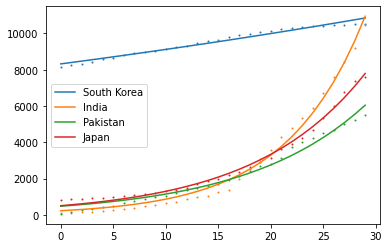

In [83]:
def f(x,A,M):
  return A*np.exp(M*x)

print("Doubles rate:")
for key in ['South Korea','India','Pakistan','Japan']:
  y=Data[key][-30:]
  x=np.arange(len(y))
  #x=x+30-len(x)
  popt,pcov=curve_fit(f,x,y)
  print(key,'- ',round(np.log(2)/popt[1],1),"days")
  plt.scatter(x,y,s=1)
  plt.plot(x,f(x,popt[0],popt[1]),label=key)
plt.legend()
plt.show()

In [0]:
def plot(param,x,y,key):
  x_new=np.arange(len(y)+30)
  n=len(param)//3
  res=0
  sat=0
  for i in range(n):
    [a,b,c]=param[3*i:3*(i+1)]
    sat+=c
    res+=c*(erf(b*(x_new-a))+1)
  
  print("Saturation: ",2*int(sat))
  '''
  plt.title(key)
  plt.ylabel("Cumulative Coronavirus Cases")
  plt.xlabel("Number of Days")
  plt.scatter(x,y)
  plt.semilogy(x_new[10:],res[10:],c='r')
  plt.show()

  plt.title(key)
  plt.ylabel("Cumulative Coronavirus Cases")
  plt.xlabel("Number of Days")
  plt.scatter(x,y)
  x_new=np.arange(10,n+30)
  plt.plot(x_new,res,c='r')
  plt.show()
  '''

  plt.title(key)
  plt.ylabel('Daily Coronavirus Cases')
  plt.xlabel("Number of Days")
  plt.scatter(x[1:],y[1:]-y[:-1])
  plt.plot(x_new[1:],res[1:]-res[:-1],c='r')
  plt.show()

In [0]:
def f1(x,a,b,c):
  return c*(erf(b*(x-a))+1)
def f2(x,a1,b1,c1,a2,b2,c2):
  return c1*(erf(b1*(x-a1))+1)+c2*(erf(b2*(x-a2))+1)
def f3(x,a1,b1,c1,a2,b2,c2,a3,b3,c3):
  return c1*(erf(b1*(x-a1))+1)+c2*(erf(b2*(x-a2))+1)+c3*(erf(b3*(x-a3))+1)

Saturation:  28010


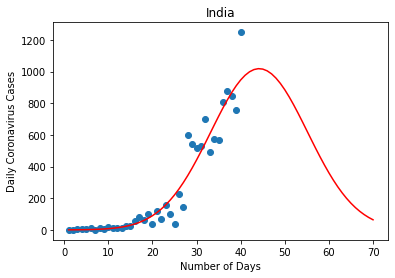

Saturation:  9538


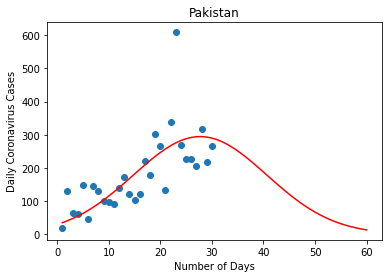

Saturation:  756294


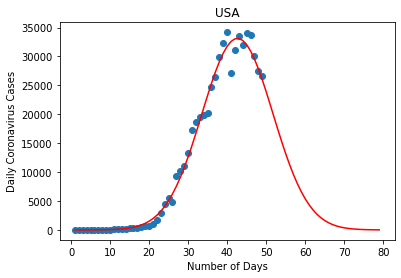

Saturation:  165340


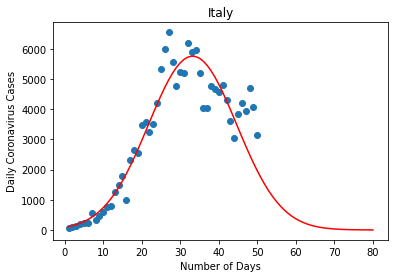

Saturation:  177652


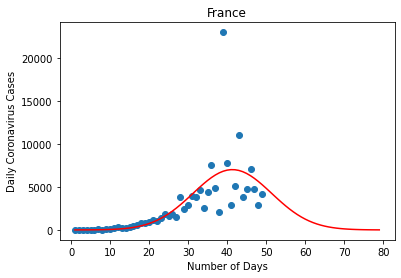

In [86]:
for key in ['India', 'Pakistan', 'USA', 'Italy','France']:
  y=np.array(Data[key])
  x=np.arange(len(y))
  
  try: popt,pcov=curve_fit(f1,x,y)
  except: continue

  plot(popt,x,y,key)

Saturation:  2615062


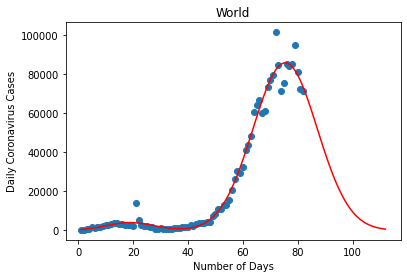

Saturation:  188960


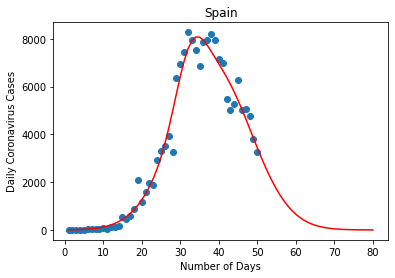

Saturation:  151838


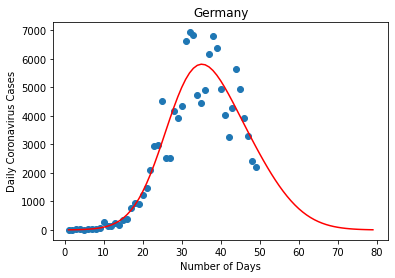

Saturation:  26784


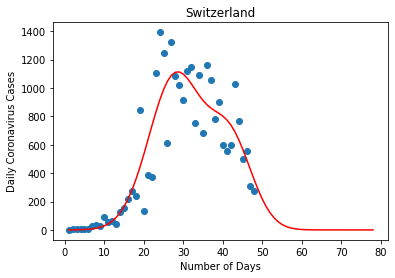

Saturation:  10926


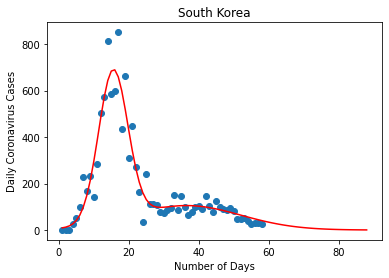

In [87]:
for key in ['World','Spain','Germany','Switzerland','South Korea']:
  y=np.array(Data[key])
  x=np.arange(len(y))
  
  try: popt,pcov=curve_fit(f2,x,y)
  except: continue

  plot(popt,x,y,key)

Saturation:  83944


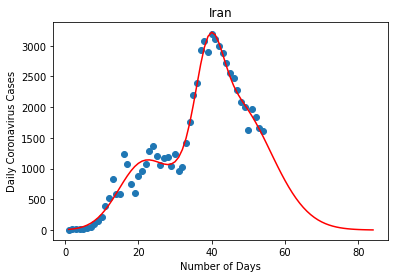

In [88]:
for key in ['Iran']:
  y=np.array(Data[key])
  x=np.arange(len(y))
  
  try: popt,pcov=curve_fit(f3,x,y)
  except: continue

  plot(popt,x,y,key)